In [55]:
using GpABC, DifferentialEquations, Distances, Plots, Distributions

# Performing the Linear Noise Approximation and conducting ABC

This notebook will guide the user through not only performing the linear noise approximation (LNA) on any system the user wishes to but will also guide the user through then using the LNA when conducting ABC for parameter estimation.

## What is the LNA? 

The below shall be a brief overview of the definition of the LNA implemented in `GpABC`, if it is incomprehensible then the rest of then notebook should guide the user through the concept of the LNA. 

Still, it is important to mathematically outline the LNA.

The LNA approximates the Chemical Master Equation (CME) by decomposing the stochastic process into two ordinary differential equations (ODEs); one describing the evolution of the mean of the trajectories and the other describing the evolution of the covaraince of the trajectories.

In other words the LNA approximates the stochastic process by looking at the mean and the covariance of the trajectories $\textbf{x}(t)$, whose evolution is described by a system of ODEs which can be seen below:

$$
\begin{align}
\frac{d\varphi}{dt}&=\mathcal{S}\textbf{f}(\boldsymbol\varphi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{f}(\boldsymbol\varphi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

Here $\textbf{S}$ is the stoichometry matrix of the system, $\textbf{f}$ is the reaction rates. 

The matrix $\mathcal{A}(t) = \mathcal{S}\mathcal{D}$ and $\mathcal{D}$ is the Jacobian of the reaction rates: $\{\mathcal{D} \}_{i,k} = \frac{\partial f_i(\boldsymbol\varphi)}{\partial \phi_k}$

These can be solved by numerical methods to describe how $\boldsymbol\varphi$ (the mean) and $\Sigma$ (the covariance) evolve with time.

The rest of the notebook should lead the user through this.

##Stochastic Three Gene Toy Example

Consider a Three Gene Example where Gene 1, 2 and 3 are represented by $g_1$, $g_2$ and $g_3$ respectively and $\textbf{g} = (g_1, g_2, g_3)^T$. The kinetic parameters of the system are represented through $k_*$. Imagine a system where the concentrations of these genes vary and depend on each other and they are determined by the equations below: 

$$
\begin{align*} 
\emptyset & \overset{\hphantom{k_{1}} \, k_{1,s} \, g_3 \hphantom{k}}{\longrightarrow}   g_1  \\ 
g_1 & \overset{\hphantom{k_{1,s}} \, k_{1,d} \,  \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 & \overset{ \hphantom{k_{1}} \,k_{2,s} \, g_1 \hphantom{k_{1,s}}}{\longrightarrow} g_1 + g_2 \\ 
g_2 & \overset{\hphantom{k_{1,s}}\, k_{2,d} \, \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 + g_2 & \overset{k_{3,s} \, k_{3,1} \, k_{3,2} }{\longrightarrow}  g_1 + g_2  + g_3 \\ 
g_3 & \overset{ \hphantom{k_{1,s}} \, k_{3,d} \, \hphantom{k_{1,s}}}{\longrightarrow}  \emptyset 
\end{align*}
$$

The reaction rates of this model is: 

 $\textbf{f}= \begin{bmatrix}
      \frac{ k_{1,s}}{1+k_{1,3} \, \textbf{g}_3}, & k_{1,d} \, \textbf{g}_1, & \frac{k_{2,s} \, k_{2,1}\, \textbf{g}_1}{1+k_{2,1} \, \textbf{g}_1}, & k_{2,d} \, \textbf{g}_2, & \frac{k_{3,s} \, k_{3,1} \, \textbf{g}_1 \,  k_{3,2} \, \textbf{g}_2}{(1+k_{3,1} \, \textbf{g}_1)(1+k_{3,2} \, \textbf{g}_2)}, & k_{3,d} \, \textbf{g}_3        
     \end{bmatrix} ^T$. 


The Stoichiometry matrix of the system is:

$$\textbf{S} =
 \begin{pmatrix}
  1 & -1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & -1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & -1  
 \end{pmatrix} $$ and the reaction rates are 
 

    
The user requires $\textbf{S}$ and $\textbf{f}$ when constructing a stochastic model of a system.

In this example, the parameters $[k_{1,s}, k_{2,s}, k_{3,s}, k_{1,d}, k_{1,d}, k_{2,d}, k_{3,d}, k_{1,3}, k_{2,1}, k_{3,1}, k_{3,1}]$ have been chosen to take values $[2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]$ 

So lets contruct $\textbf{S}$ and $\textbf{f}$:

In [1]:
S = [1.0 -1.0 0.0 0.0 0.0 0.0;  # stoichometry matrix 
     0.0 0.0 1.0 -1.0 0.0 0.0;
     0.0 0.0 0.0 0.0 1.0 -1.0]

params = [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0] #parameters

reaction_rate_function = function(x,params)
    f = [params[1]/(1+params[7]*x[3]),
        params[4]*x[1],
        params[2]*params[8]*x[1]/(1+params[8]*x[1]),
        params[5]*x[2],
        params[3]*params[9]*x[1]*params[10]*x[2]/(1+params[9]*x[1])/(1+params[10]*x[2]),
        params[6]*x[3]]
    return f
end

(::#1) (generic function with 1 method)

Notice how the reaction rates must be provided as a function.

The original ODE model by the relationship $\dot{\textbf{g}} = \textbf{S} \, \textbf{f} $.

An example of this can be seen below. Notice how in `GeneReg` the only thing defining the ODE is:

$\textbf{S} \, \textbf{f}$ .

The initial conditions, timspan, solver and saveat are arbitrary.

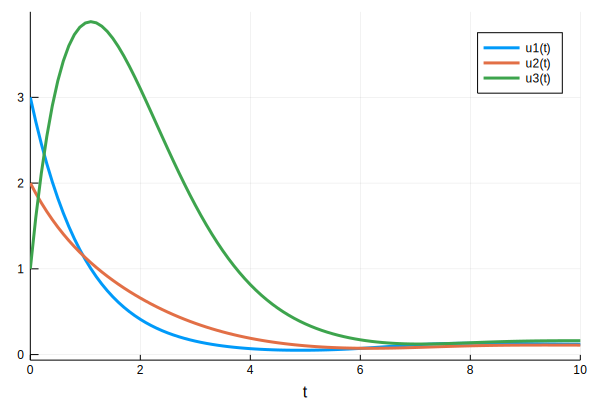

In [28]:
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = RK4()
saveat = 0.1

ODE_solution = GeneReg(params, Tspan, x0, solver, saveat)

plot(ODE_solution)

## Stochastic Example

Before diving straight into the LNA lets make `GeneReg` stochastic to see what happens:

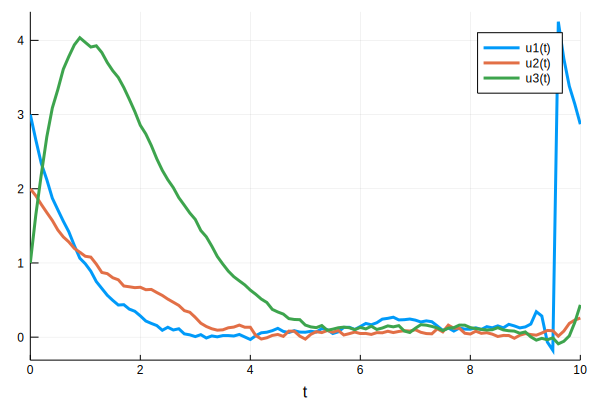

In [29]:
StochGeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::StochasticDiffEq.StochasticDiffEqAlgorithm, dt::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end
    
  function sigma_3GeneReg(dx, x, par, t)
    dx[1] = 0.1
    dx[2] = 0.1
    dx[3] = 0.1
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = SDEProblem(ODE_3GeneReg, sigma_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, dt=dt)

  return Obs
end

Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = EM()
dt = 0.1

SDE_solution = StochGeneReg(params, Tspan, x0, solver, saveat)

plot(SDE_solution)

## Computing the LNA

Now if the user wishes to do the LNA of the above stochastic problem it is simply done by setting up an LNAInput structure:

In [30]:
volume = 1.0
input = LNAInput(params, S, reaction_rate_function, volume)

GpABC.LNAInput([2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0], [1.0 -1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 -1.0], #1, 1.0)

Now if the user wishes to see the results from the two ODEs:
    
$$
\begin{align}
\frac{d\varphi}{dt}&=\mathcal{S}\textbf{f}(\boldsymbol\varphi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{f}(\boldsymbol\varphi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

The user must simply provide the initial condtions in the form of (initial conditions of the species, initial covariance) and then call `compute_LNA`. 

This returns a `LNA` structure which holds the solutions to the above ODEs. The means, $\varphi$ can be called by `lna.traj_means` and the covariance $\Sigma$ can be called by `lna.traj_covars`. The time points the system of ODEs were solved for can be called by `lna.time_points`. 

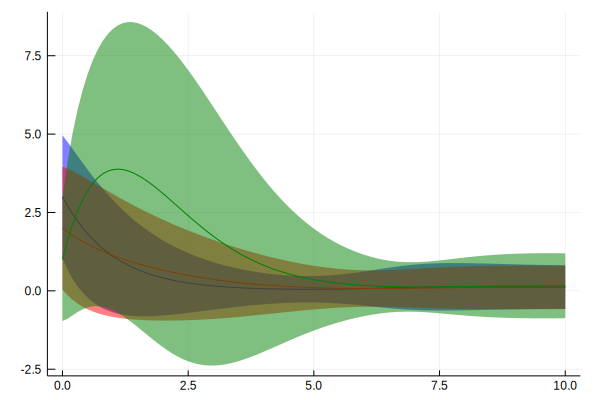

In [44]:
x0 = ([3.0, 2.0, 1.0], eye(3)) #initial conditions
solver = RK4()
saveat = 0.1

lna = compute_LNA(input, x0, Tspan, saveat)

covariance = lna.traj_covars
t = lna.time_points
mean  = lna.traj_means


variance = zeros(size(S)[1], length(t))
for (idx, elt) in enumerate(covariance)
    variance[:, idx] = diag(elt)
end

plot(t, mean[1,:], ribbon=1.96*sqrt.(variance[1,:]), c=:blue, leg=false)
plot!(t, mean[2,:], ribbon=1.96*sqrt.(variance[2,:]), c=:red, leg=false)
plot!(t, mean[3,:], ribbon=1.96*sqrt.(variance[3,:]), c=:green, leg=false)

The three means are plotted with the shaded areas being the 95% confidence intervals.

## Sampling from the LNA

The LNA gives the mean of the tracjectories and the covariance between them; hence a single trajectory can be sampled from a Multivariate Normal distribution. The function `sample_LNA_trajectories` automatically does this. 

The user can also sample more than one trajectory, which are then averaged, by changing `n_samples`. The effect of varying `n_samples` is shown below:

  0.000464 seconds (2.31 k allocations: 117.967 KiB)


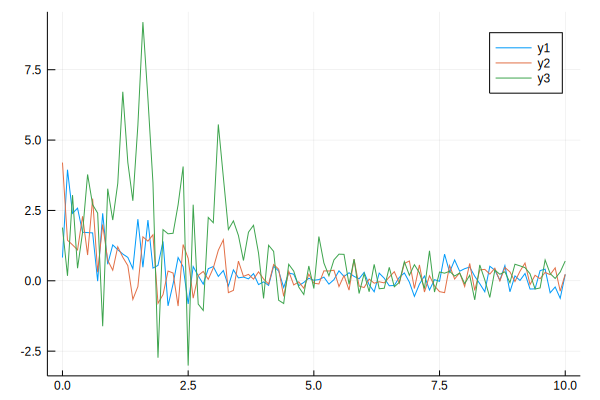

In [65]:
n_samples = 1

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000332 seconds (2.24 k allocations: 134.125 KiB)


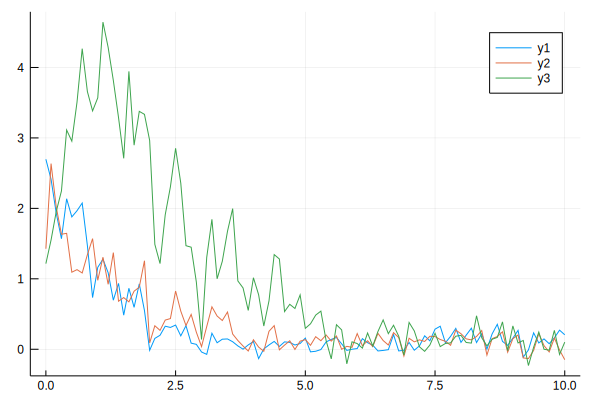

In [66]:
n_samples = 10

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000783 seconds (2.24 k allocations: 353.484 KiB)


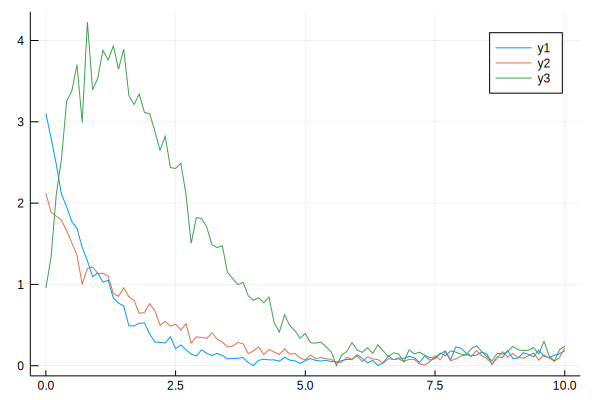

In [67]:
n_samples = 100

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

## Rejection ABC using the LNA

In [68]:
n_design_points = 200
priors = [Uniform(0., 5.), Uniform(0., 5.), Uniform(0., 5.)]
distance_metric = euclidean
reference_data = lna_trajectories

X, y = get_training_data(input, n_samples, n_design_points, priors, "keep_all",
        distance_metric, reference_data, x0, Tspan, saveat)

([1.26921 4.00846 3.87826; 1.85519 0.553762 4.94401; … ; 4.14352 2.64318 0.270573; 2.69564 4.3962 4.7076], [12.3821, 10.9708, 13.8015, 10.8835, 14.1993, 13.7809, 11.973, 13.1594, 14.096, 12.3674  …  14.3043, 16.7367, 12.4655, 14.1008, 13.1983, 14.3524, 10.2819, 11.7742, 17.8383, 12.0351])

In [69]:
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
n_var_params = length(priors)
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance", legend=false) for idx = 1:n_var_params]
plot(plts..., size=(900, 300))

Exception InterruptException() for hyperparameters [4.44904, 2.69112, 0.865003, -0.903602, -1.82693]


LoadError: [91mInterruptException:[39m

2018-08-01T15:29:43.488 Accepted 0/100000 particles (100 batches of size 1000).
2018-08-01T15:29:44.974 Accepted 0/200000 particles (200 batches of size 1000).
2018-08-01T15:29:46.468 Accepted 0/300000 particles (300 batches of size 1000).
2018-08-01T15:29:48.112 Accepted 0/400000 particles (400 batches of size 1000).
2018-08-01T15:29:49.862 Accepted 0/500000 particles (500 batches of size 1000).
2018-08-01T15:29:51.446 Accepted 0/600000 particles (600 batches of size 1000).
2018-08-01T15:29:53.01 Accepted 0/700000 particles (700 batches of size 1000).
2018-08-01T15:29:54.489 Accepted 0/800000 particles (800 batches of size 1000).
2018-08-01T15:29:56.034 Accepted 0/900000 particles (900 batches of size 1000).
2018-08-01T15:29:57.637 Accepted 0/1000000 particles (1000 batches of size 1000).


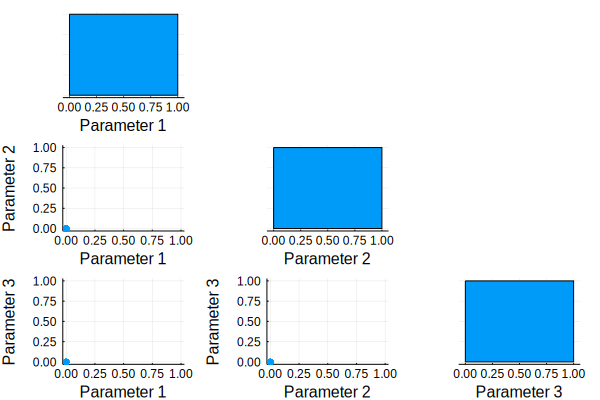

In [64]:
function predict_distance(p::AbstractArray{Float64})
    result = gp_regression(p,gpem)[1]
    return result
end

n_particles = 1000
batch_size = 1000
max_iter = 1000

emu_rej_input = EmulatedABCRejectionInput(n_var_params,  
  n_particles,
  1.0,
  priors,     
  predict_distance,
  batch_size,
  max_iter)

emu_result = ABCrejection(emu_rej_input, reference_data, progress_every=100)

plot(emu_result)

In [ ]:
threshold_schedule = [3.0, 2.0, 1.0]

sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    "keep_all",
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)